In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Flickr8k_Dataset.zip", 'r')
zip_ref.extractall("/content/flikr_images")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Flickr8k_text (1).zip", 'r')
zip_ref.extractall("/content/flikr_text")
zip_ref.close()

Mounted at /content/drive/


In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
# load vgg19 model
model = VGG19()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
# print(model.summary())

In [ ]:
images_dir = '/content/flikr_images/Flicker8k_Dataset'

# extract features from image
features = {}

for img_name in tqdm(os.listdir(images_dir)):
  # print(img_name)
  # load the image from file
  img_path = images_dir + '/' + img_name
  image = load_img(img_path, target_size=(224, 224))
  # convert image pixels to numpy array
  image = img_to_array(image)
  # reshape data for model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  # preprocess image for vgg
  image = preprocess_input(image)
  # extract features
  feature = model.predict(image, verbose=0)
  # get image ID
  image_id = img_name.split('.')[0]
  # store feature
  features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
pickle.dump(features, open('/content/drive/MyDrive/features2.pkl', 'wb'))



In [ ]:
# load features from pickle
with open('/content/drive/MyDrive/features2.pkl', 'rb') as f:
    features = pickle.load(f)

In [ ]:
train_path = '/content/flikr_text/Flickr_8k.trainImages.txt'
train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n")

test_path = '/content/flikr_text/Flickr_8k.testImages.txt'
test_images = open(test_path, 'r', encoding = 'utf-8').read().split("\n")

In [ ]:
images_list = list(train_images) + list(test_images)

In [ ]:
images_list = [x for x in images_list if x]

In [ ]:
images_ids = []
for k in images_list:
  id_name = k.split(".")[0]
  images_ids.append(id_name)

In [ ]:
features_final = dict((k, features[k]) for k in list(images_ids))

In [ ]:
token_path = '/content/flikr_text/Flickr8k.token.txt'
text = open(token_path, 'r', encoding = 'utf-8').read()

In [ ]:
def load_description(text):
    mapping = dict()
    for line in text.split("\n"):
        token = line.split("\t")
        if len(line) < 2:   # remove short descriptions
            continue
        img_id = token[0].split('.')[0] # name of the image
        img_des = token[1]              # description of the image
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)
    return mapping
  
mapping = load_description(text)

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40460

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

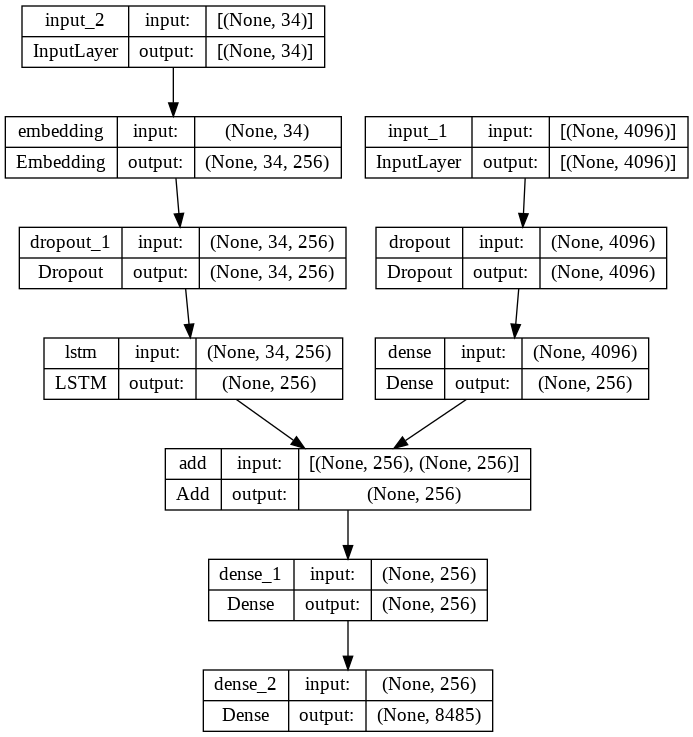

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)


In [ ]:
mapping["2258277193_586949ec62"]

['startseq people waiting for the subway endseq',
 'startseq some people looking out windows in large building endseq',
 'startseq three people are waiting on train platform endseq',
 'startseq three people standing at station endseq',
 'startseq two woman and one man standing near train tracks endseq']

In [ ]:
train.remove("2258277193_586949ec62")

In [ ]:
# train the model
epochs = 15
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 36s 156ms/step - loss: 2.3195


In [ ]:
# save the model
model.save('/content/drive/MyDrive/best_model.h5')

In [ ]:
model2 = model()
model2.load('/content/drive/MyDrive/best_model.h5')

In [ ]:
import tensorflow
model = tensorflow.keras.models.load_model('/content/drive/MyDrive/best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.541878
BLEU-2: 0.316588


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/content/flikr_images/Flicker8k_Dataset', image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq boy smiles in front of stony wall in city endseq
startseq little boy is standing on the street while man in overalls is working on stone wall endseq
startseq young boy runs aross the street endseq
startseq young child is walking on stone paved street with metal pole and man behind him endseq
startseq smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him endseq
--------------------Predicted--------------------
startseq two little girls are walking down the street endseq


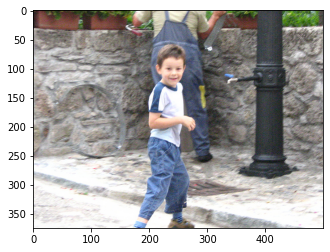

In [ ]:
generate_caption("1015118661_980735411b.jpg")